# Dependency code

In [1]:
import imp
import os
import sys
import numpy as np
import glob
import cmdbench

fp, pathname, description = imp.find_module('benchmark', ['../lib'])
benchmark = imp.load_module('benchmark', fp, pathname, description)

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

# Software versions

In [2]:
!conda run --name snippy snippy --version

snippy 4.6.0



# Benchmarking

## Input data and constants

In [3]:
input_dir = '../data/input-files/reads'
input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
input_samples.sort()
print(input_samples)

snippy_out = 'snippy-output'
nproc = 32

reference_genome = "../data/input-files/2011C-3609.fasta"

sample_sizes = [1,10,20,30,40,50,60,70,80]
#sample_sizes = [3]

benchmark.create_folder_if_doesnt_exist(snippy_out)
benchmark.clean_if_exists(snippy_out)

['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655', '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907', '2014D-0067', '2014D-0068', '2014D-0070', '2014D-0189', 'CFSAN002349', 'CFSAN023463', 'CFSAN023464', 'CFSAN023465', 'CFSAN023466', 'CFSAN023467', 'CFSAN023468', 'CFSAN023469', 'CFSAN023470', 'CFSAN023471', 'D5663', 'D7316', 'D7319', 'D7320', 'D7321', 'D7322', 'D7323', 'D7324', 'D7327', 'D7328', 'D7329', 'D7330', 'D7331', 'D7333', 'D7334', 'MOD1_LS1000', 'MOD1_LS1003', 'MOD1_LS1004', 'MOD1_LS1005', 'MOD1_LS1006', 'MOD1_LS1008', 'MOD1_LS1009', 'MOD1_LS1010', 'MOD1_LS1011', 'MOD1_LS982', 'MOD1_LS985', 'MOD1_LS989', 'MOD1_LS994', 'MOD1_LS995', 'MOD1_LS996', 'MOD1_LS997', 'MOD1_LS998', 'PNUSA000194', 'PNUSA000195', 'PNUSA000196', 'PNUSAL000730', 'PNUSAL000870', 'PNUSAL000957', 'PNUSAL001024', 'SIM_CFSAN000189', 'SIM_CFSAN000191', 'SIM_CFSAN000211', 'SIM_CFSAN000212', 'SIM_CFSAN000228', 'SIM_CFSAN000661', 'SIM_CFSAN000669', 'SIM_CFSAN000700', 'SIM_CFSAN000752', 'SIM_

## Benchmark functions

In [4]:
def reset_func():
    benchmark.clean_if_exists(snippy_out)
    
def sampling_func(sample_size):
    samples = input_samples[:sample_size]
    
    samples_tab_file_lines = []
    
    input_dir_abs = os.path.abspath(input_dir)
    reference_genome_abs = os.path.abspath(reference_genome)

    for sample in samples:
        samples_tab_file_line = f"{sample}\t{input_dir_abs}/{sample}_1.fastq.gz\t{input_dir_abs}/{sample}_2.fastq.gz"
        samples_tab_file_lines.append(samples_tab_file_line)
        
    samples_tab_file_content = "\n".join(samples_tab_file_lines)
        
    file = open(f"{snippy_out}/samples.tab", "w") 
    file.write(samples_tab_file_content + "\n")
    file.close()
    
    os.system(f"conda run --name snippy snippy-multi {snippy_out}/samples.tab --ref {reference_genome_abs} --cpus 1 > {snippy_out}/snippy-commands.sh")
    
    # Split commands so I can run alignments in parallel
    os.system(f'grep -v "snippy-core" {snippy_out}/snippy-commands.sh > {snippy_out}/snippy-align-commands.sh')
    os.system(f'grep "snippy-core" {snippy_out}/snippy-commands.sh > {snippy_out}/snippy-core-commands.sh')
    
    return samples

## Benchmark

In [5]:
snippy_align_command = {
    "use_parallel": False,
    "command": f"conda run --name snippy cd {snippy_out}; parallel -j {nproc} -a snippy-align-commands.sh"
}

snippy_core_command = {
    "use_parallel": False,
    "command": f"conda run --name snippy cd {snippy_out}; bash snippy-core-commands.sh"
}

multibench_results, debug_str = benchmark.multibench.multi_cmdbench({
        "build_tree": [snippy_align_command, snippy_core_command]
    },
    reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results = benchmark.benchmark_list_to_results, active_output_print = False
)

print('Done')

Done


# Save and reload results

In [6]:
save_path = "snippy_results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

benchmark.multibench.save_multibench_results(multibench_results, samples_per_sample_size, save_path)

multibench_results, samples_per_sample_size = benchmark.multibench.read_multibench_results(save_path)
print(samples_per_sample_size)

[['2014C-3598'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067,', '2014D-0068,', '2014D-0070,', '2014D-0189,', 'CFSAN002349,', 'CFSAN023463,', 'CFSAN023464,', 'CFSAN023465,', 'CFSAN023466,', 'CFSAN023467,', 'CFSAN023468'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067,', '2014D-0068,', '2014D-0070,', '2014D-0189,', 'CFSAN002349,', 'CFSAN023463,', 'CFSAN023464,', 'CFSAN023465,', 'CFSAN023466,', 'CFSAN023467,', 'CFSAN023468,', 'CFSAN023469,', 'CFSAN023470,', 'CFSAN023471,', 'D5663,', 'D7316,', 'D7319,', 'D7320,', 'D7321,', 'D7322,', 'D7323'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-

# Plot

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'runtime': 237.86, 'memory': 1166831616.0, 'disk_read': 3232520538.0, 'disk_write': 2713214527.0}, {'runtime': 590.0, 'memory': 8588877824.0, 'disk_read': 44039578980.0, 'disk_write': 37513617171.0}, {'runtime': 625.16, 'memory': 10632966144.0, 'disk_read': 64559665818.0, 'disk_write': 55091788806.0}, {'runtime': 668.71, 'memory': 16900186112.0, 'disk_read': 126469287783.0, 'disk_write': 108705163671.0}, {'runtime': 805.1, 'memory': 27972816896.0, 'disk_read': 209004115179.0, 'disk_write': 180248607507.0}, {'runtime': 864.41, 'memory': 33357791232.0, 'disk_read': 257438862629.0, 'disk_write': 221996080880.0}, {'runtime': 1006.7, 'memory': 38348611584.0, 'disk_read': 309061070508.0, 'disk_write': 266573283946.0}, {'runtime': 1062.75, 'memory': 39404191744.0, 'disk_read': 332233829467.0, 'disk_write': 286028234519.0}, {'runtime': 1126.09, 'memory': 39619694592.0, 'disk_read': 352854495436.0, 'disk_write': 303060690143.0}]


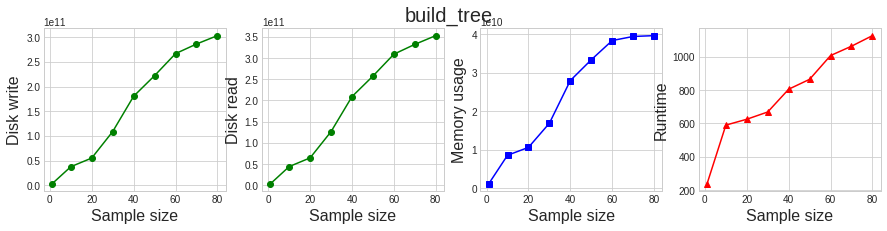

In [8]:
# Typer command Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "build_tree")